<a href="https://colab.research.google.com/github/Cyrus-White/HW-Project-Files-/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


<ipython-input-8-fcb80c5f04c7>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2994.0476 - val_loss: 3101.1929
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2890.3491 - val_loss: 3055.7673
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2336.7441 - val_loss: 2480.6375
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1864.5984 - val_loss: 1918.4451
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1711.1349 - val_loss: 1725.4539
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1657.4271 - val_loss: 1605.7073
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1503.3627 - val_loss: 1508.2365
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1433.4666 - val_loss: 1419.9127
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1347.6849 - val_loss: 1337.5079
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1299.9236 - val_loss: 1261.0287
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1172.3910 - val_loss: 1190.4116
Epoch 12

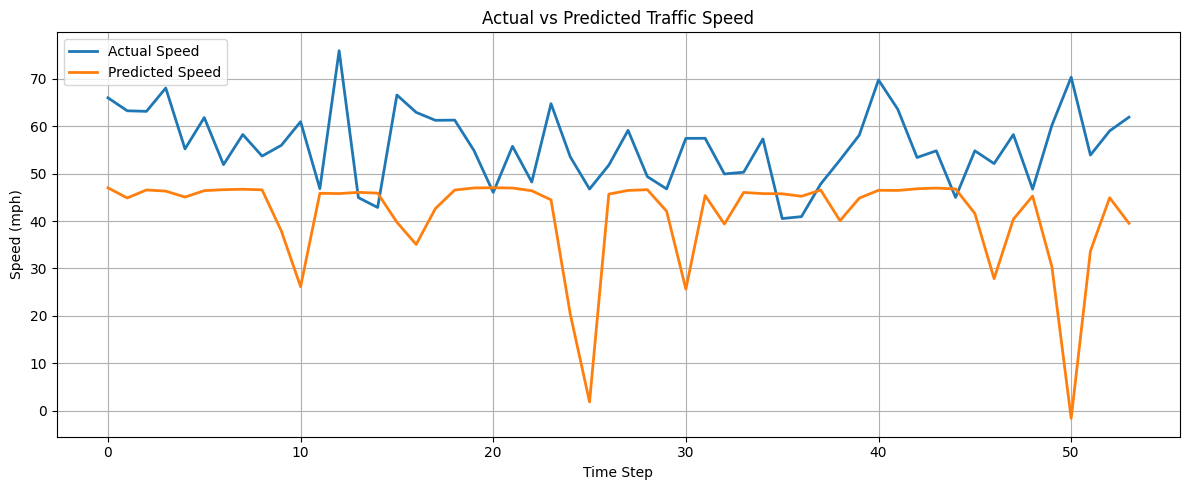

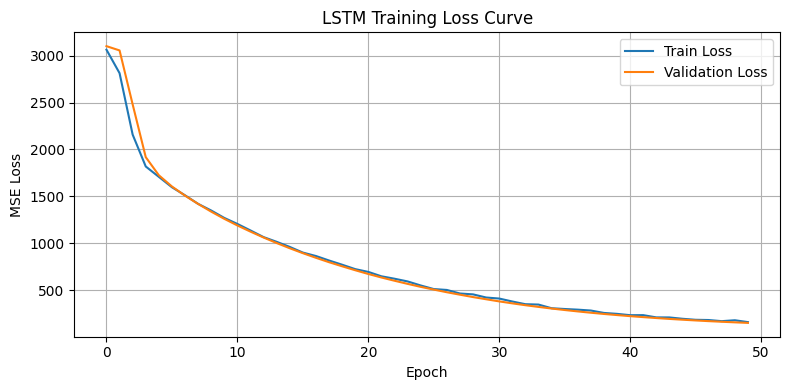

✅ Evaluation on Test Set:
MAE:  15.27 mph
RMSE: 19.92 mph
R²:   -5.5155


In [8]:
# STEP 0: Install and import dependencies
!pip install tensorflow pandas matplotlib seaborn scikit-learn openpyxl --quiet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# STEP 1: Load full-year Excel file uploaded to Colab (adjust if needed)
file_path = "/content/Traffic_Weather_Holiday_2015.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# STEP 2: Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Create lag features & moving statistics
df['lag_1'] = df['Avg_Traffic_Speed_mph'].shift(1)
df['rolling_mean_3'] = df['Avg_Traffic_Speed_mph'].rolling(window=3).mean()
df['rolling_std_3'] = df['Avg_Traffic_Speed_mph'].rolling(window=3).std()

# Drop rows with NaNs due to lag
df.dropna(inplace=True)

# STEP 3: Prepare features and scale
features = ['Avg_Temperature_F', 'Precipitation_in', 'Is_Holiday', 'dayofweek',
            'month', 'year', 'lag_1', 'rolling_mean_3', 'rolling_std_3']
target = 'Avg_Traffic_Speed_mph'

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generate LSTM sequences
def create_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data[i:i + seq_len])
        y_seq.append(y_data[i + seq_len])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 7
X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split into train, val, test (70%, 15%, 15%)
total_len = len(X_seq)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)

X_train, y_train = X_seq[:train_len], y_seq[:train_len]
X_val, y_val = X_seq[train_len:train_len+val_len], y_seq[train_len:train_len+val_len]
X_test, y_test = X_seq[train_len+val_len:], y_seq[train_len+val_len:]

# STEP 4: Build and train LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# STEP 5: Evaluate on test set
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Fixed here
r2 = r2_score(y_test, y_pred)

# STEP 6: Plot predictions vs actual
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Speed', linewidth=2)
plt.plot(y_pred, label='Predicted Speed', linewidth=2)
plt.title('Actual vs Predicted Traffic Speed')
plt.xlabel('Time Step')
plt.ylabel('Speed (mph)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/lstm_speed_prediction_comparison.png')
plt.show()

# STEP 7: Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/lstm_loss_curve.png')
plt.show()

# Output final evaluation
print("✅ Evaluation on Test Set:")
print(f"MAE:  {mae:.2f} mph")
print(f"RMSE: {rmse:.2f} mph")
print(f"R²:   {r2:.4f}")
